## Model Choice Overview

### EDA-informed top features
1. `number_inpatient`
2. `number_emergency`
3. `number_outpatient`
4. `number_diagnoses`
5. `admission_source_id`

### Context
- Class imbalance exists (`NO` dominates), therefore macro metrics and recall monitoring are mandatory.
- Interpretability matters for hospital stakeholders, so transparent baselines remain in scope.


| Dataset Characteristic | Primary Algorithm | Secondary Algorithm | Rationale |
|---|---|---|---|
| Medium tabular dataset | Random Forest | Logistic Regression | Good non-linear signal capture + interpretable baseline |
| High-dimensional encoded features | Logistic Regression | Gradient Boosting | Handles sparse one-hot structure efficiently |
| Class imbalance | SMOTE + RF/XGB | Class-weighted Logistic | Improves minority recall while preserving comparability |
| Stakeholder explainability need | Logistic Regression | Calibrated Tree-based model | Easier policy discussion and threshold setting |


Import Models

In [51]:
import sys
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

PROJECT_ROOT = Path.cwd().resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

import notebook_checks as notebook_checks_mod
import styling.styling as styling_mod
import model_pipeline as model_pipeline_mod

importlib.reload(notebook_checks_mod)
importlib.reload(styling_mod)
importlib.reload(model_pipeline_mod)

from config import get_config

build_model_candidates = model_pipeline_mod.build_model_candidates
compute_binary_pr_curve = model_pipeline_mod.compute_binary_pr_curve
compute_error_analysis = model_pipeline_mod.compute_error_analysis
establish_dummy_baselines = model_pipeline_mod.establish_dummy_baselines
evaluate_models_cv = model_pipeline_mod.evaluate_models_cv
fit_and_evaluate_test = model_pipeline_mod.fit_and_evaluate_test
load_model_data = model_pipeline_mod.load_model_data
run_model_pipeline = model_pipeline_mod.run_model_pipeline
feature_error_patterns = model_pipeline_mod.feature_error_patterns
confidence_strategy = model_pipeline_mod.confidence_strategy
check_calibration = model_pipeline_mod.check_calibration

assert_feature_alignment = notebook_checks_mod.assert_feature_alignment
assert_no_missing_values = notebook_checks_mod.assert_no_missing_values
assert_valid_target_labels = notebook_checks_mod.assert_valid_target_labels
build_reproducibility_footer = notebook_checks_mod.build_reproducibility_footer

apply_notebook_style = styling_mod.apply_notebook_style
build_eda_output_paths = styling_mod.build_eda_output_paths
build_artifact_path = styling_mod.build_artifact_path
save_table_snapshot = styling_mod.save_table_snapshot


Import Data

In [52]:
cfg = get_config(PROJECT_ROOT)
apply_notebook_style()
output_path, table_output_path = build_eda_output_paths(PROJECT_ROOT)

NOTEBOOK_ID = '03'
def fig_path(section_id: str, slug: str):
    return build_artifact_path(output_path, NOTEBOOK_ID, section_id, slug, 'png')

def table_path(section_id: str, slug: str, extension: str = 'png'):
    return build_artifact_path(table_output_path, NOTEBOOK_ID, section_id, slug, extension)

data = load_model_data(cfg, include_binary=True)

X_train = data.X_train
X_test = data.X_test
y_train = data.y_train
y_test = data.y_test
y_train_binary = data.y_train_binary
y_test_binary = data.y_test_binary

assert_feature_alignment(X_train, X_test)
assert_no_missing_values(X_train, 'X_train_encoded')
assert_no_missing_values(X_test, 'X_test_encoded')
assert_valid_target_labels(y_train, 'y_train_encoded', allowed_labels=(0, 1, 2))
assert_valid_target_labels(y_test, 'y_test_encoded', allowed_labels=(0, 1, 2))

print(f"X_train: {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test : {y_test.shape}")
if y_test_binary is not None:
    print(f"y_test_binary : {y_test_binary.shape}")


X_train: (79394, 185)
X_test : (19855, 185)
y_train: (79394,)
y_test : (19855,)
y_test_binary : (19855,)


## Why These Models?

- **Logistic Regression**: strongest interpretability baseline, useful for stakeholder trust.
- **Random Forest**: robust non-linear tabular benchmark with low preprocessing sensitivity.
- **XGBoost (if available)**: performance-oriented candidate for complex interaction capture.

All are evaluated with consistent CV and test metrics under class-imbalance handling.


## Baseline Model

### Baseline Strategy

Level 1 (dummy baselines): sanity check that learned models beat naive strategies.

Level 2 (candidate models): compare interpretable vs high-capacity models using the same CV setup.


In [53]:
baseline_results = establish_dummy_baselines(
    X_train,
    y_train,
    cv_folds=5,
    random_state=cfg.random_state,
)

display(baseline_results.sort_values('cv_f1_macro_mean', ascending=False))


,model,cv_f1_macro_mean,cv_recall_macro_mean,cv_accuracy_mean
1,Dummy::stratified,0.336747,0.336753,0.426657
2,Dummy::uniform,0.308935,0.333245,0.336751
0,Dummy::most_frequent,0.232517,0.333333,0.535569


### Candidate Model Training and Evaluation


In [54]:
pipeline_results = run_model_pipeline(
    config=cfg,
    cv_folds=5,
    include_baselines=True,
    save_artifacts=True,
)

cv_results = pipeline_results['cv_results']
test_results = pipeline_results['test_results']
fitted_models = pipeline_results['fitted_models']
best_model_name = pipeline_results['best_model_name']
best_model = pipeline_results['best_model']
model_reports = pipeline_results['model_reports']
saved_paths = pipeline_results['saved_paths']

print(f"Best model by CV priority (<30 recall, then precision): {best_model_name}")
print(f"Saved best model path: {saved_paths.get('best_model', cfg.model_path)}")



Best model by CV priority (<30 recall, then precision): LogisticRegression
Saved best model path: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/data/final/best_model.joblib


Classification report (best untuned model):
              precision    recall  f1-score   support

           0     0.6595    0.5860    0.6205     10632
           1     0.4555    0.3294    0.3824      6997
           2     0.1784    0.4286    0.2519      2226

    accuracy                         0.4779     19855
   macro avg     0.4311    0.4480    0.4183     19855
weighted avg     0.5337    0.4779    0.4953     19855



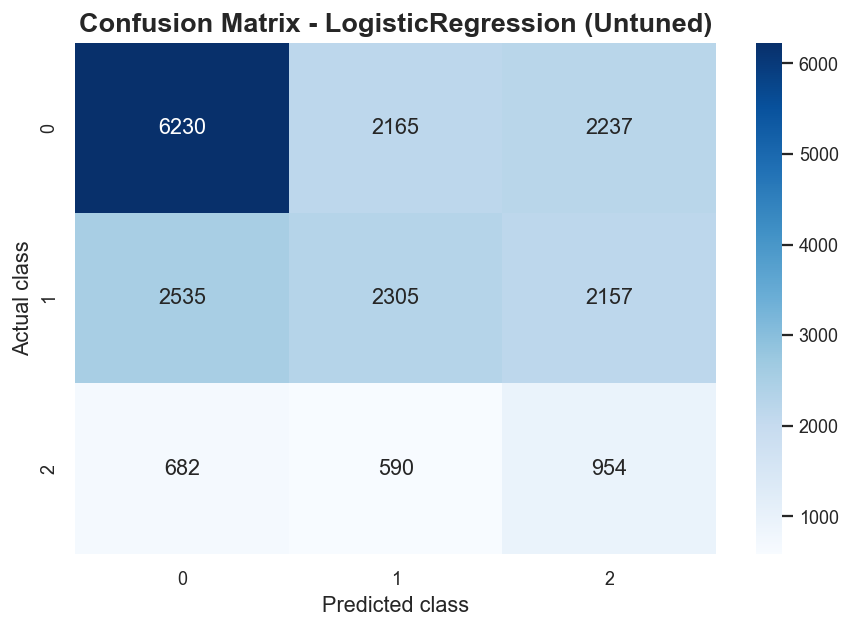

In [55]:
y_pred_best = best_model.predict(X_test)

print('Classification report (best untuned model):')
print(classification_report(y_test, y_pred_best, digits=4))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} (Untuned)')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.tight_layout()
plt.savefig(fig_path('04', 'confusion_matrix_untuned'), dpi=220)
plt.show()


### Different Models

In [56]:
comparison_df = cv_results.merge(test_results, on='model', how='left')
comparison_df = comparison_df.sort_values('cv_f1_macro_mean', ascending=False)

display(comparison_df)

save_table_snapshot(
    comparison_df,
    table_path('04', 'model_comparison_summary'),
    title='Model Choice - CV/Test Comparison',
    index=False,
)
comparison_df.to_csv(table_path('04', 'model_comparison_summary', 'csv'), index=False)


,model,cv_f1_macro_mean,cv_f1_macro_std,cv_precision_macro_mean,cv_precision_weighted_mean,cv_recall_macro_mean,cv_recall_lt30_mean,cv_accuracy_mean,test_accuracy,test_precision_macro,test_precision_weighted,test_recall_macro,test_recall_lt30,test_f1_macro,test_auc_ovr_macro
0,LogisticRegression,0.417607,0.002780,0.429370,0.532054,0.445532,0.417835,0.477706,0.477915,0.431129,0.533665,0.447988,0.428571,0.418271,0.642468
1,XGBoost,0.412672,0.004246,0.532956,0.565438,0.424055,0.041952,0.589465,0.590682,0.537034,0.567545,0.423610,0.035040,0.410315,0.681159
2,RandomForest,0.385997,0.002211,0.502754,0.546981,0.406920,0.013797,0.579389,0.581113,0.511827,0.551295,0.408639,0.012579,0.387504,0.653929


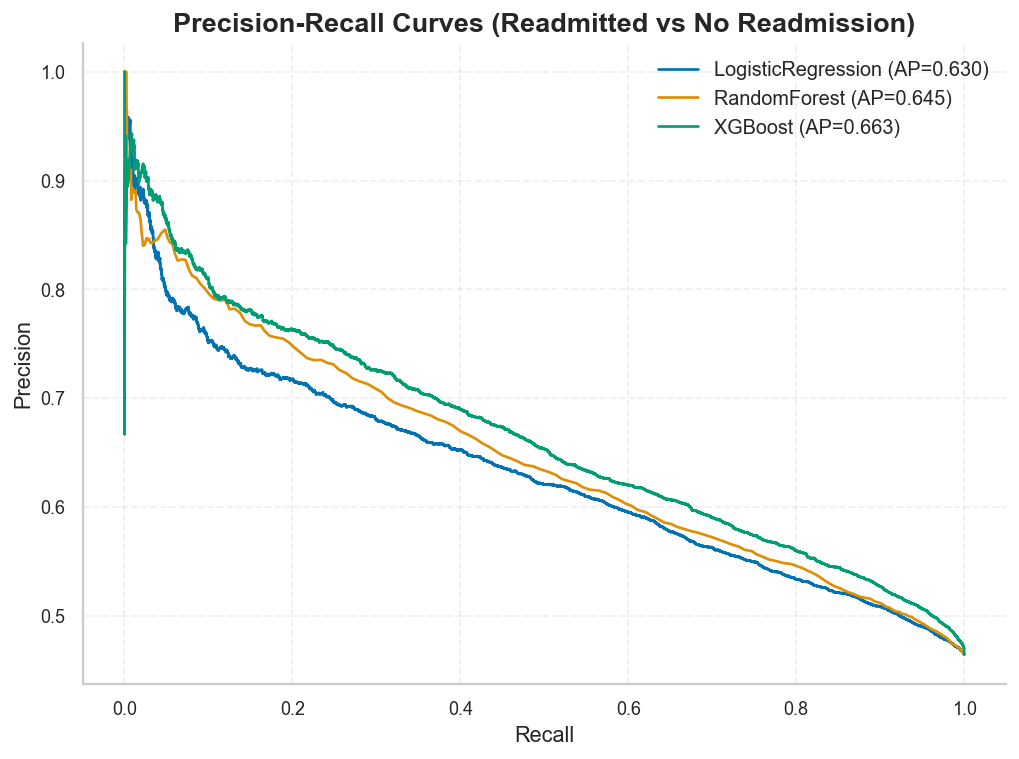

In [57]:
if y_test_binary is None:
    print('Binary target files not found. Skipping PR analysis.')
else:
    plt.figure(figsize=(8, 6))
    for model_name, model in fitted_models.items():
        pr_df, ap = compute_binary_pr_curve(model, X_test, y_test_binary)
        plt.plot(pr_df['recall'], pr_df['precision'], label=f"{model_name} (AP={ap:.3f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Readmitted vs No Readmission)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_path('04', 'precision_recall_curves_all_models'), dpi=220)
    plt.show()


In [58]:
recall_rows = []
for model_name, report in model_reports.items():
    recall_rows.append(
        {
            'model': model_name,
            'recall_class_0_NO': report.get('0', {}).get('recall', np.nan),
            'recall_class_1_GT30': report.get('1', {}).get('recall', np.nan),
            'recall_class_2_LT30': report.get('2', {}).get('recall', np.nan),
            'recall_macro': report.get('macro avg', {}).get('recall', np.nan),
        }
    )

recall_breakdown = pd.DataFrame(recall_rows).sort_values('recall_macro', ascending=False)
display(recall_breakdown)

save_table_snapshot(
    recall_breakdown,
    table_path('04', 'recall_breakdown_by_class'),
    title='Model Choice - Recall Breakdown by Class',
    index=False,
)
recall_breakdown.to_csv(table_path('04', 'recall_breakdown_by_class', 'csv'), index=False)


,model,recall_class_0_NO,recall_class_1_GT30,recall_class_2_LT30,recall_macro
0,LogisticRegression,0.585967,0.329427,0.428571,0.447988
2,XGBoost,0.826185,0.409604,0.035040,0.423610
1,RandomForest,0.830888,0.382450,0.012579,0.408639


## Hyperparameter Tuning


In [59]:
from sklearn.metrics import make_scorer, recall_score

models_for_tuning = build_model_candidates(cfg.random_state)
base_tune_model = models_for_tuning[best_model_name]

if best_model_name == 'LogisticRegression':
    param_distributions = {
        'model__C': uniform(0.01, 10),
        'model__penalty': ['l2'],
    }
elif best_model_name == 'RandomForest':
    param_distributions = {
        'model__n_estimators': randint(150, 500),
        'model__max_depth': randint(4, 30),
        'model__min_samples_split': randint(2, 20),
        'model__min_samples_leaf': randint(1, 10),
    }
else:
    # XGBoost branch
    param_distributions = {
        'model__n_estimators': randint(150, 500),
        'model__max_depth': randint(3, 10),
        'model__learning_rate': uniform(0.01, 0.20),
        'model__subsample': uniform(0.6, 0.4),
        'model__colsample_bytree': uniform(0.6, 0.4),
    }

priority_scoring = {
    'recall_lt30': make_scorer(recall_score, labels=[2], average='macro', zero_division=0),
    'precision_macro': 'precision_macro',
    'f1_macro': 'f1_macro',
}

def refit_lt30_recall_then_precision(cv_results):
    ranking = (
        pd.DataFrame(cv_results)
        .assign(_idx=lambda d: d.index)
        .sort_values(
            ['mean_test_recall_lt30', 'mean_test_precision_macro', 'mean_test_f1_macro'],
            ascending=[False, False, False],
        )
    )
    return int(ranking.iloc[0]['_idx'])

random_search = RandomizedSearchCV(
    estimator=base_tune_model,
    param_distributions=param_distributions,
    n_iter=15,
    scoring=priority_scoring,
    refit=refit_lt30_recall_then_precision,
    cv=5,
    random_state=cfg.random_state,
    n_jobs=-1,
    verbose=1,
)
random_search.fit(X_train, y_train)

tuned_model = random_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

best_idx = random_search.best_index_
best_cv_recall_lt30 = float(random_search.cv_results_['mean_test_recall_lt30'][best_idx])
best_cv_precision_macro = float(random_search.cv_results_['mean_test_precision_macro'][best_idx])
best_cv_f1_macro = float(random_search.cv_results_['mean_test_f1_macro'][best_idx])

print('Best params:')
print(random_search.best_params_)
print(f"Best CV recall_lt30: {best_cv_recall_lt30:.4f}")
print(f"Best CV precision_macro: {best_cv_precision_macro:.4f}")
print(f"Best CV f1_macro: {best_cv_f1_macro:.4f}")



Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params:
{'model__C': 2.1333911067827613, 'model__penalty': 'l2'}
Best CV recall_lt30: 0.4170
Best CV precision_macro: 0.4297
Best CV f1_macro: 0.4182


Tuning objective: maximize `f1_macro` while preserving minority-class recall.


In [60]:
from sklearn.metrics import f1_score, precision_score, recall_score
import joblib

tuned_test_f1 = f1_score(y_test, y_pred_tuned, average='macro')
tuned_test_precision_macro = precision_score(y_test, y_pred_tuned, average='macro', zero_division=0)
tuned_test_recall_lt30 = recall_score(y_test, y_pred_tuned, labels=[2], average='macro', zero_division=0)

summary_row = pd.DataFrame(
    [
        {
            'selected_base_model': best_model_name,
            'best_cv_recall_lt30_tuned': best_cv_recall_lt30,
            'best_cv_precision_macro_tuned': best_cv_precision_macro,
            'best_cv_f1_macro_tuned': best_cv_f1_macro,
            'test_recall_lt30_tuned': tuned_test_recall_lt30,
            'test_precision_macro_tuned': tuned_test_precision_macro,
            'test_f1_macro_tuned': tuned_test_f1,
        }
    ]
)
display(summary_row)

tuned_model_path = cfg.final_dir / f"{best_model_name.lower()}_tuned.joblib"
joblib.dump(tuned_model, tuned_model_path)
print(f"Tuned model saved to: {tuned_model_path}")



,selected_base_model,best_cv_recall_lt30_tuned,best_cv_precision_macro_tuned,best_cv_f1_macro_tuned,test_recall_lt30_tuned,test_precision_macro_tuned,test_f1_macro_tuned
0,LogisticRegression,0.41705,0.429657,0.418236,0.428571,0.431171,0.418305


Tuned model saved to: /Users/casimircasparuhlig/Desktop/classification-project-casimiruhlig/data/final/logisticregression_tuned.joblib


In [61]:
# Feature importance / impact inspection
if hasattr(tuned_model.named_steps['model'], 'feature_importances_'):
    raw_importance = tuned_model.named_steps['model'].feature_importances_
    importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': raw_importance})
    importance_df = importance_df.sort_values('importance', ascending=False)
else:
    coef = tuned_model.named_steps['model'].coef_
    importance = np.abs(coef).mean(axis=0)
    importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importance})
    importance_df = importance_df.sort_values('importance', ascending=False)

importance_top = importance_df.head(25)
display(importance_top)

save_table_snapshot(
    importance_top,
    table_path('06', 'tuned_model_feature_importance_top25'),
    title='Model Choice - Tuned Model Feature Importance (Top 25)',
    index=False,
)
importance_top.to_csv(table_path('06', 'tuned_model_feature_importance_top25', 'csv'), index=False)


,feature,importance
174,number_inpatient,0.222987
32,medical_specialty_Other_Unknown,0.133245
183,procedure_diversification,0.089692
173,number_emergency,0.074468
17,admission_source_id_Transfer_Hospital,0.072320
45,diag_1_Other,0.069660
167,discharge_disposition_id,0.068558
170,num_procedures,0.062037
46,diag_1_Respiratory,0.057304
29,medical_specialty_Emergency_Critical_Care,0.054611


In [62]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv_compare_rows = []
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.random_state)
for label, model in {
    'best_untuned': best_model,
    'best_tuned': tuned_model,
}.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv_strategy,
        scoring={'f1_macro': 'f1_macro', 'recall_macro': 'recall_macro', 'accuracy': 'accuracy'},
        n_jobs=-1,
    )
    cv_compare_rows.append(
        {
            'model_variant': label,
            'cv_f1_macro_mean': scores['test_f1_macro'].mean(),
            'cv_recall_macro_mean': scores['test_recall_macro'].mean(),
            'cv_accuracy_mean': scores['test_accuracy'].mean(),
        }
    )

cv_compare_df = pd.DataFrame(cv_compare_rows)
display(cv_compare_df)

save_table_snapshot(
    cv_compare_df,
    table_path('06', 'tuned_vs_untuned_cv_metrics'),
    title='Model Choice - Tuned vs Untuned CV Metrics',
    index=False,
)
cv_compare_df.to_csv(table_path('06', 'tuned_vs_untuned_cv_metrics', 'csv'), index=False)


,model_variant,cv_f1_macro_mean,cv_recall_macro_mean,cv_accuracy_mean
0,best_untuned,0.417607,0.445532,0.477706
1,best_tuned,0.417640,0.445506,0.477782


## Visualize performance

/var/folders/dj/mn6229p97s99ftdv_bdyz9cc0000gn/T/ipykernel_22715/167678730.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='model', y='cv_f1_macro_mean', ax=axes[0], palette='Blues')
/var/folders/dj/mn6229p97s99ftdv_bdyz9cc0000gn/T/ipykernel_22715/167678730.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x='model', y='test_f1_macro', ax=axes[1], palette='Greens')


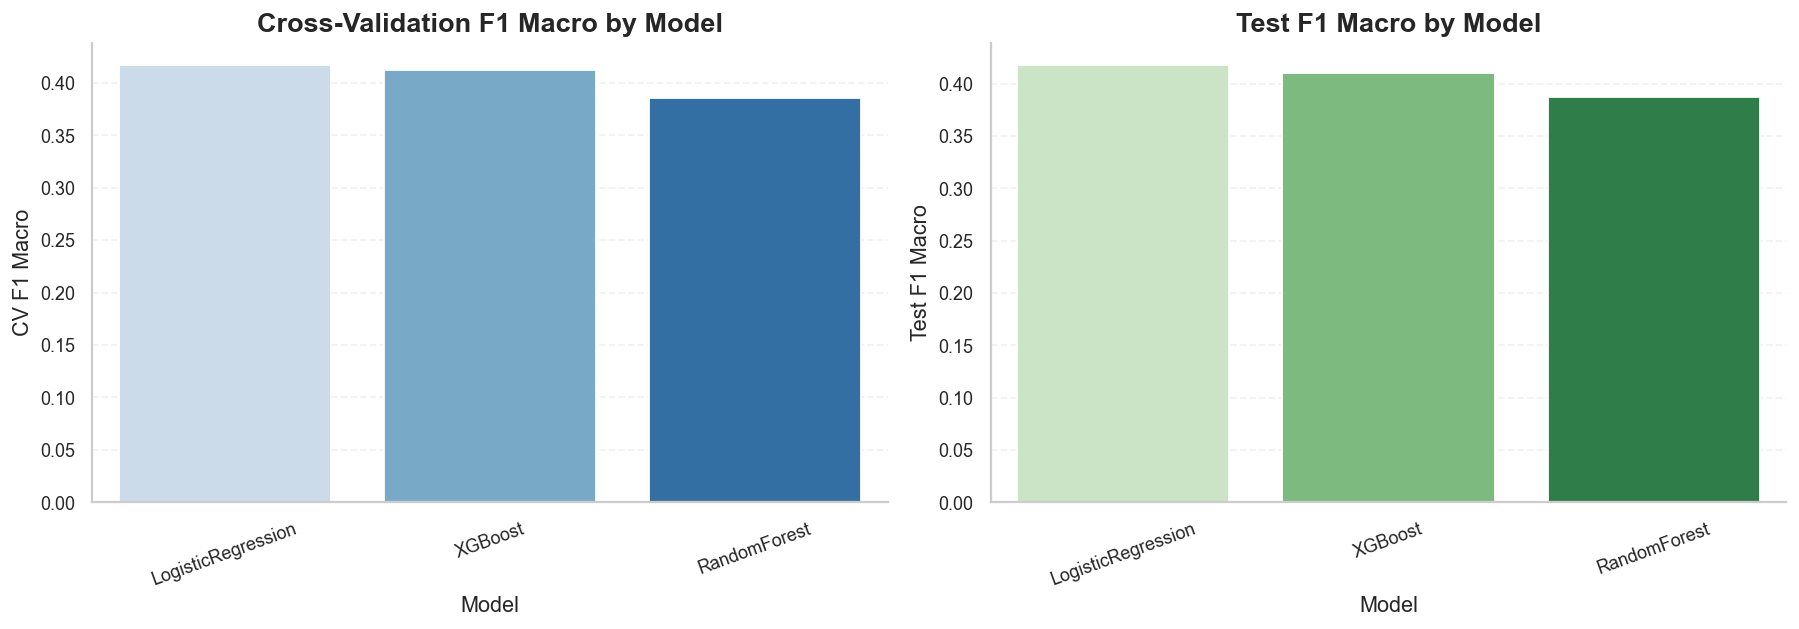

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=comparison_df, x='model', y='cv_f1_macro_mean', ax=axes[0], palette='Blues')
axes[0].set_title('Cross-Validation F1 Macro by Model')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('CV F1 Macro')
axes[0].tick_params(axis='x', rotation=20)

sns.barplot(data=comparison_df, x='model', y='test_f1_macro', ax=axes[1], palette='Greens')
axes[1].set_title('Test F1 Macro by Model')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Test F1 Macro')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig(fig_path('07', 'model_f1_comparison_bars'), dpi=220)
plt.show()


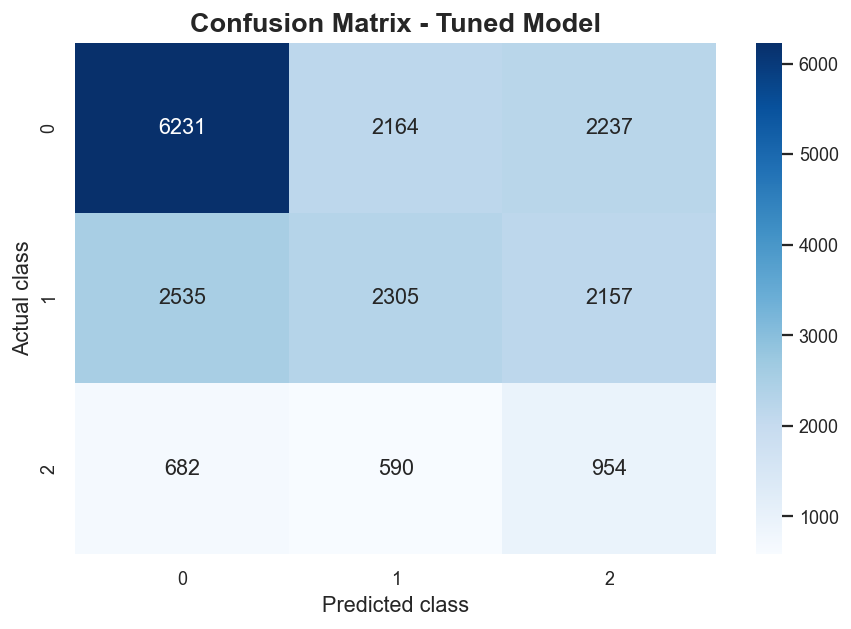

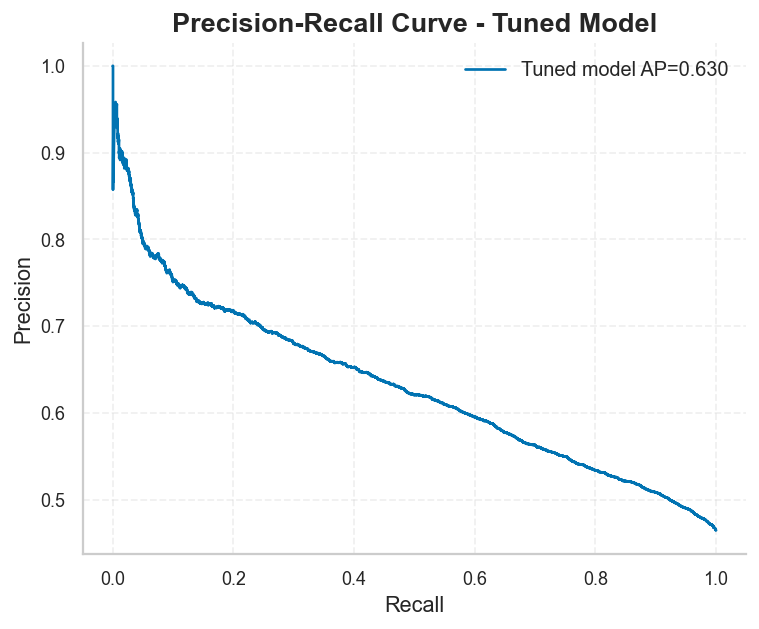

In [64]:
y_pred_tuned = tuned_model.predict(X_test)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Model')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.tight_layout()
plt.savefig(fig_path('07', 'confusion_matrix_tuned'), dpi=220)
plt.show()

if y_test_binary is not None:
    pr_tuned, ap_tuned = compute_binary_pr_curve(tuned_model, X_test, y_test_binary)
    plt.figure(figsize=(6, 5))
    plt.plot(pr_tuned['recall'], pr_tuned['precision'], label=f'Tuned model AP={ap_tuned:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Tuned Model')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(fig_path('07', 'precision_recall_tuned'), dpi=220)
    plt.show()


In [65]:
untuned_best_row = cv_results.iloc[0]
improvement_recall_lt30 = best_cv_recall_lt30 - float(untuned_best_row['cv_recall_lt30_mean'])
improvement_precision_macro = best_cv_precision_macro - float(untuned_best_row['cv_precision_macro_mean'])

print('Business impact summary')
print(f"Best untuned CV recall_lt30      : {float(untuned_best_row['cv_recall_lt30_mean']):.4f}")
print(f"Best tuned CV recall_lt30        : {best_cv_recall_lt30:.4f}")
print(f"Best untuned CV precision_macro  : {float(untuned_best_row['cv_precision_macro_mean']):.4f}")
print(f"Best tuned CV precision_macro    : {best_cv_precision_macro:.4f}")
print(f"Best tuned CV f1_macro           : {best_cv_f1_macro:.4f}")
print(f"Gain in recall_lt30 from tuning  : {improvement_recall_lt30:.4f}")
print(f"Gain in precision_macro tuning   : {improvement_precision_macro:.4f}")



Business impact summary
Best untuned CV recall_lt30      : 0.4178
Best tuned CV recall_lt30        : 0.4170
Best untuned CV precision_macro  : 0.4294
Best tuned CV precision_macro    : 0.4297
Best tuned CV f1_macro           : 0.4182
Gain in recall_lt30 from tuning  : -0.0008
Gain in precision_macro tuning   : 0.0003


## Reflect on Model Behavior and Trade-Offs


### Error Detection and Confidence Strategy

Use error composition and confidence thresholds to decide when automated predictions need clinician review.


In [66]:
error_summary = compute_error_analysis(
    model=tuned_model,
    X_test=X_test,
    y_test=y_test,
    confidence_threshold=0.80,
)

display(pd.Series(error_summary, name='value').to_frame())


,value
error_rate,0.522035
total_errors,10365.000000
total_rows,19855.000000
high_confidence_share,0.002317
high_confidence_accuracy,0.891304
low_confidence_accuracy,0.477005


In [67]:
y_pred_tuned = tuned_model.predict(X_test)
errors = y_pred_tuned != y_test

if 'importance_df' in locals() and not importance_df.empty:
    top_features = importance_df['feature'].head(5).tolist()
else:
    top_features = X_test.columns[:5].tolist()

rows = []
for feat in top_features:
    rows.append(
        {
            'feature': feat,
            'correct_mean': float(X_test.loc[~errors, feat].mean()),
            'error_mean': float(X_test.loc[errors, feat].mean()),
            'absolute_gap': float(abs(X_test.loc[~errors, feat].mean() - X_test.loc[errors, feat].mean())),
        }
    )

error_feature_df = pd.DataFrame(rows).sort_values('absolute_gap', ascending=False)
display(error_feature_df)


,feature,correct_mean,error_mean,absolute_gap
0,number_inpatient,0.223816,0.435389,0.211574
3,number_emergency,0.082249,0.126681,0.044431
1,medical_specialty_Other_Unknown,0.472497,0.512494,0.039997
2,procedure_diversification,0.207569,0.172869,0.034700
4,admission_source_id_Transfer_Hospital,0.068388,0.043222,0.025165


In [68]:
threshold_rows = []
for threshold in [0.60, 0.70, 0.80, 0.90]:
    metrics = compute_error_analysis(
        model=tuned_model,
        X_test=X_test,
        y_test=y_test,
        confidence_threshold=threshold,
    )
    threshold_rows.append(
        {
            'threshold': threshold,
            'high_confidence_share': metrics.get('high_confidence_share', np.nan),
            'high_confidence_accuracy': metrics.get('high_confidence_accuracy', np.nan),
            'low_confidence_accuracy': metrics.get('low_confidence_accuracy', np.nan),
        }
    )

confidence_strategy_df = pd.DataFrame(threshold_rows)
display(confidence_strategy_df)

save_table_snapshot(
    confidence_strategy_df,
    table_path('08', 'confidence_strategy_thresholds'),
    title='Model Choice - Confidence Threshold Strategy',
    index=False,
)
confidence_strategy_df.to_csv(table_path('08', 'confidence_strategy_thresholds', 'csv'), index=False)

repro_footer = build_reproducibility_footer(cfg.random_state)
display(repro_footer)
save_table_snapshot(
    repro_footer,
    table_path('99', 'reproducibility_footer'),
    title='Model Choice - Reproducibility Footer',
    index=False,
)
repro_footer.to_csv(table_path('99', 'reproducibility_footer', 'csv'), index=False)


,threshold,high_confidence_share,high_confidence_accuracy,low_confidence_accuracy
0,0.6,0.088492,0.645418,0.461708
1,0.7,0.021959,0.754587,0.471754
2,0.8,0.002317,0.891304,0.477005
3,0.9,0.000201,0.750000,0.477910


,timestamp_utc,python_version,platform,random_seed,numpy,pandas,sklearn,matplotlib,seaborn
0,2026-02-18T13:15:54+00:00,3.11.0,macOS-26.2-arm64-arm-64bit,42,1.26.4,2.2.0,1.7.2,3.10.6,0.13.2


## Feature-Based Error Analysis


In [69]:
# Use top tuned-model features to inspect how errors differ from correct predictions
y_pred_tuned = tuned_model.predict(X_test)

if 'importance_df' in locals() and not importance_df.empty:
    top_features = importance_df['feature'].head(5).tolist()
else:
    top_features = X_test.columns[:5].tolist()

print(f"Top features used for error pattern scan: {top_features[:3]}")
feature_error_patterns(
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred_tuned,
    top_features=top_features,
)


Top features used for error pattern scan: ['number_inpatient', 'medical_specialty_Other_Unknown', 'procedure_diversification']
Feature Analysis for Errors:

number_inpatient:
  Correct predictions: 0.224
  Error predictions: 0.435
  Difference: 0.212

medical_specialty_Other_Unknown:
  Correct predictions: 0.472
  Error predictions: 0.512
  Difference: 0.040

procedure_diversification:
  Correct predictions: 0.208
  Error predictions: 0.173
  Difference: 0.035


## Confidence-Based Decision Framework and Calibration


Business Strategy (threshold: 0.8):
Auto-process: 46 samples (0.2%)
Manual review: 19809 samples (99.8%)
Workload reduction: 0.2%


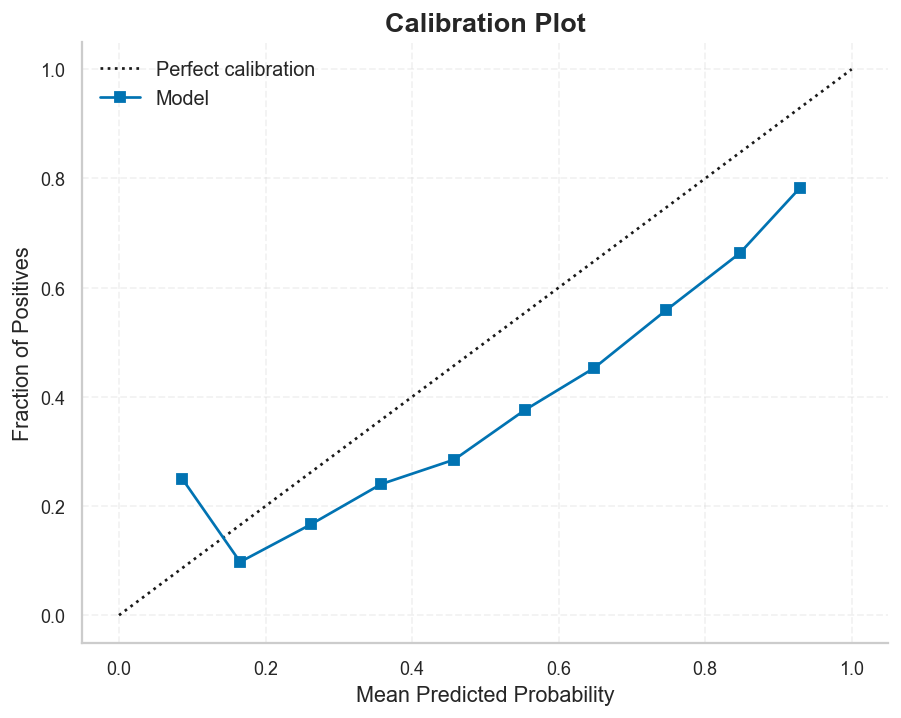

Calibration Error: 0.151
🔴 Poorly calibrated


In [70]:
# Operational strategy: auto-process high-confidence predictions, review low-confidence ones
confidence_strategy(
    model=tuned_model,
    X_test=X_test,
    confidence_threshold=0.80,
)

# Calibration check (binary proxy target required)
if y_test_binary is None:
    print('Binary target not available. Skipping calibration plot.')
else:
    check_calibration(
        model=tuned_model,
        X_test=X_test,
        y_test=y_test_binary,
    )


Create Lurning Curves

## Bootstrap Confidence Intervals

## Expert To-Do

- Add probability calibration report (Brier score + calibration curves).
- Add fairness slice metrics by race/age/payer for tuned model.
- Add decision-threshold optimization linked to hospital intervention capacity.
